In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('data/contract_awards_in_investment_project_financing_09-10-2024.csv')
df.head()

,As of Date,Fiscal Year,Region,Borrower Country / Economy,Borrower Country / Economy Code,Project ID,Project Name,Project Global Practice,Procurement Category,Procurement Method,WB Contract Number,Contract Description,Borrower Contract Reference Number,Contract Signing Date,Supplier ID,Supplier,Supplier Country / Economy,Supplier Country / Economy Code,Supplier Contract Amount (USD),Review type
0,09-Oct-2024,2020,SOUTH ASIA,Afghanistan,AF,P122235,AF Irrigation Restoration and Development Project,"Agriculture, Fishing and Forestry",Civil Works,Request for Bids,1621166,Abpashak River Bank Protection Scheme in Gresh...,MEW-REF-QR501-LOT1,22-Jan-2020,413420.0,BRIGHT PEARL CONST.CO,Afghanistan,AF,1355819.28,Post
1,09-Oct-2024,2020,SOUTH ASIA,Afghanistan,AF,P125597,Kabul Municipal Development Program,"Transportation;Water, Sanitation and Waste Man...",Civil Works,Request for Bids,1632271,"Upgrading Infrastructure of Gozar 24, Dis. 12 ...",KMDP/W-94/U,21-Jan-2020,491163.0,"HIKMATULLAH KHAN NASIR ROAD, BUILDING & CONSTR...",Afghanistan,AF,649856.99,Post
2,09-Oct-2024,2020,SOUTH ASIA,Afghanistan,AF,P122235,AF Irrigation Restoration and Development Project,"Agriculture, Fishing and Forestry",Goods,Request for Bids,1625013,Supply and Installation of Snow Pack Analyzers...,MEW-REF-G246,21-Jan-2020,427383.0,ASCENT AFG GROUP OF CO CONSTRUCTION & ENGINEERING,Afghanistan,AF,137725.00,Post
3,09-Oct-2024,2020,SOUTH ASIA,Afghanistan,AF,P122235,AF Irrigation Restoration and Development Project,"Agriculture, Fishing and Forestry",Goods,Request for Bids,1625013,Supply and Installation of Snow Pack Analyzers...,MEW-REF-G246,21-Jan-2020,450443.0,RK ENGINEERING CORPORATION,India,IN,137725.00,Post
4,09-Oct-2024,2020,SOUTH ASIA,Afghanistan,AF,P125597,Kabul Municipal Development Program,"Transportation;Water, Sanitation and Waste Man...",Civil Works,Request for Bids,1617803,Upgrading Infrastructure of Tapa e Karte Naw T...,KMDP/W-100/T,21-Jan-2020,490859.0,AFGHAN BUILDERS CONSORTIUM,Afghanistan,AF,649219.82,Post


In [4]:
grouped_df = df.groupby(by = ['Project ID', 'WB Contract Number'])['Supplier Contract Amount (USD)'].sum().reset_index()
display(grouped_df)

,Project ID,WB Contract Number,Supplier Contract Amount (USD)
0,P050529,1540714,97000.00
1,P050529,1541294,80236.13
2,P050529,1541332,79969.00
3,P055120,1545554,901914.00
4,P064836,1545100,4293699.78
...,...,...,...
242435,P507066,1793773,48051.81
242436,P507066,1794892,14257.30
242437,P507066,1795803,1221688.96
242438,P507066,1796335,469908.62


Top borrowing/supplying countries
Trends spending by region/country/

In [5]:
new_rows = []
for index, row in df.iterrows():
    if ';' not in str(row['Project Global Practice']):
        new_rows.append(row)
        continue
    practices = str(row['Project Global Practice']).split(';')
    for practice in practices:
        new_row = row.copy()
        new_row['Project Global Practice'] = practice.strip()
        new_rows.append(new_row)

new_df = pd.DataFrame(new_rows)

In [6]:
new_df['Project Global Practice'].value_counts().head(20)

Project Global Practice
Agriculture, Fishing and Forestry              97805
Public Administration                          63206
Industry, Trade and Services                   57381
Social Protection                              45651
Water, Sanitation and Waste Management         42964
Education                                      39624
Transportation                                 35993
Health                                         35544
Information and Communications Technologies    31531
Energy and Extractives                         18119
Financial Sector                                6644
Name: count, dtype: int64

In [5]:
total_sum_per_country = df.groupby('Borrower Country / Economy')['Supplier Contract Amount (USD)'].sum().reset_index()
display(total_sum_per_country)

,Borrower Country / Economy,Supplier Contract Amount (USD)
0,Afghanistan,1.532588e+09
1,Africa,1.242595e+07
2,Albania,3.956975e+08
3,Angola,8.386034e+08
4,Argentina,2.763313e+09
...,...,...
148,Western and Central Africa,4.659929e+09
149,World,4.286469e+06
150,"Yemen, Republic of",6.661016e+05
151,Zambia,5.569871e+08


In [6]:
total_sum_per_country['Supplier Contract Amount (Billion USD)'] = total_sum_per_country['Supplier Contract Amount (USD)'] / 1e9
display(total_sum_per_country[['Borrower Country / Economy', 'Supplier Contract Amount (Billion USD)']])

,Borrower Country / Economy,Supplier Contract Amount (Billion USD)
0,Afghanistan,1.532588
1,Africa,0.012426
2,Albania,0.395697
3,Angola,0.838603
4,Argentina,2.763313
...,...,...
148,Western and Central Africa,4.659929
149,World,0.004286
150,"Yemen, Republic of",0.000666
151,Zambia,0.556987


In [9]:
total_sum_per_region = df.groupby('Region')['Supplier Contract Amount (USD)'].sum().reset_index()
display(total_sum_per_region)

,Region,Supplier Contract Amount (USD)
0,AFRICA,1.242595e+07
1,EAST ASIA AND PACIFIC,1.571064e+10
2,EUROPE AND CENTRAL ASIA,1.897252e+10
3,Eastern and Southern Africa,2.776031e+10
4,LATIN AMERICA AND CARIBBEAN,1.074041e+10
5,MIDDLE EAST AND NORTH AFRICA,6.482670e+09
6,OTHER,4.544489e+06
7,SOUTH ASIA,3.017187e+10
8,Western and Central Africa,2.183748e+10


In [11]:
total_sum_per_region['Supplier Contract Amount (Billion USD)'] = total_sum_per_region['Supplier Contract Amount (USD)'] / 1e9
display(total_sum_per_region[['Region', 'Supplier Contract Amount (Billion USD)']])

,Region,Supplier Contract Amount (Billion USD)
0,AFRICA,0.012426
1,EAST ASIA AND PACIFIC,15.710639
2,EUROPE AND CENTRAL ASIA,18.972524
3,Eastern and Southern Africa,27.760310
4,LATIN AMERICA AND CARIBBEAN,10.740414
5,MIDDLE EAST AND NORTH AFRICA,6.482670
6,OTHER,0.004544
7,SOUTH ASIA,30.171871
8,Western and Central Africa,21.837479


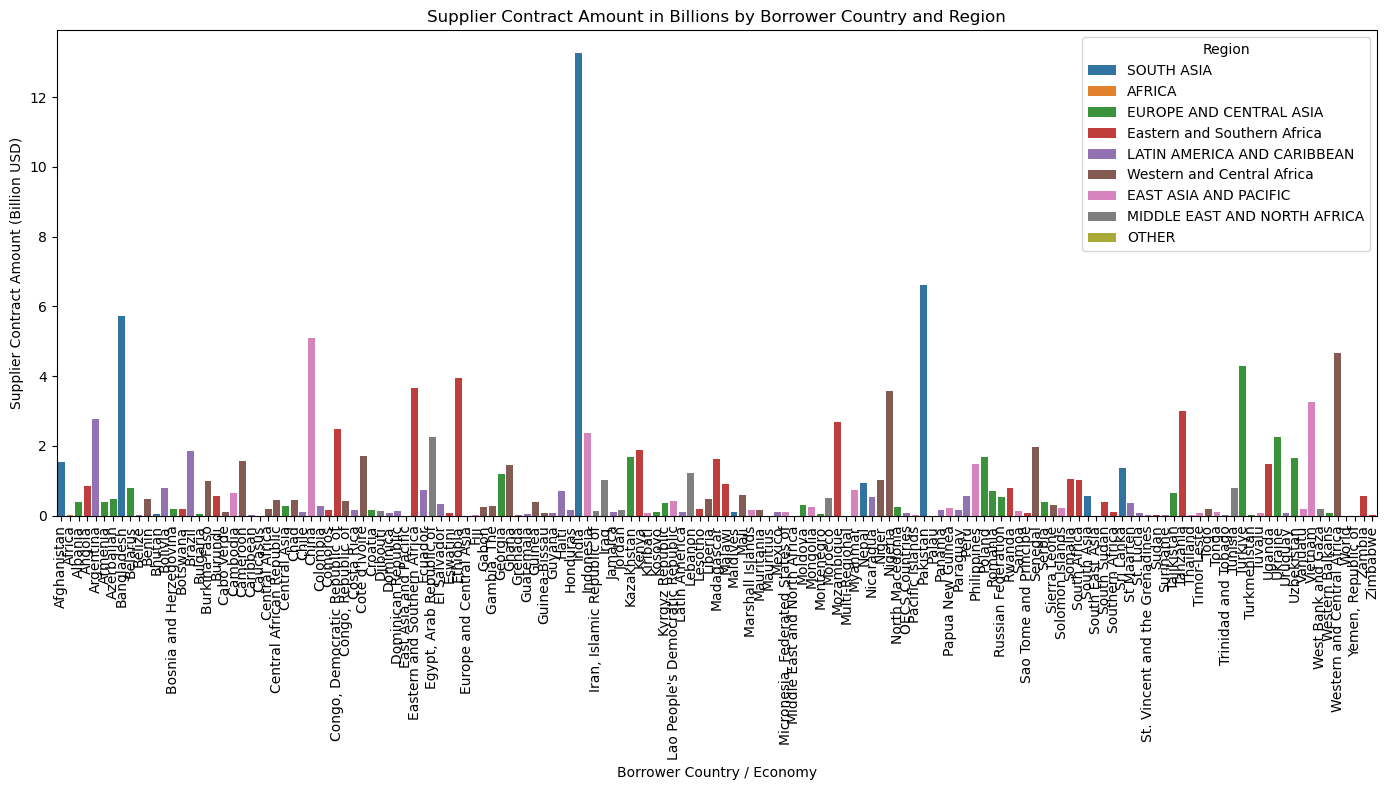

In [12]:
# Calculate the supplier contract amount in billions for each country
df['Supplier Contract Amount (Billion USD)'] = df['Supplier Contract Amount (USD)'] / 1e9

# Group by Borrower Country / Economy and Region
country_region_sum = df.groupby(['Borrower Country / Economy', 'Region'])['Supplier Contract Amount (Billion USD)'].sum().reset_index()

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(data=country_region_sum, x='Borrower Country / Economy', y='Supplier Contract Amount (Billion USD)', hue='Region')
plt.xticks(rotation=90)
plt.title('Supplier Contract Amount in Billions by Borrower Country and Region')
plt.xlabel('Borrower Country / Economy')
plt.ylabel('Supplier Contract Amount (Billion USD)')
plt.legend(title='Region')
plt.tight_layout()
plt.show()

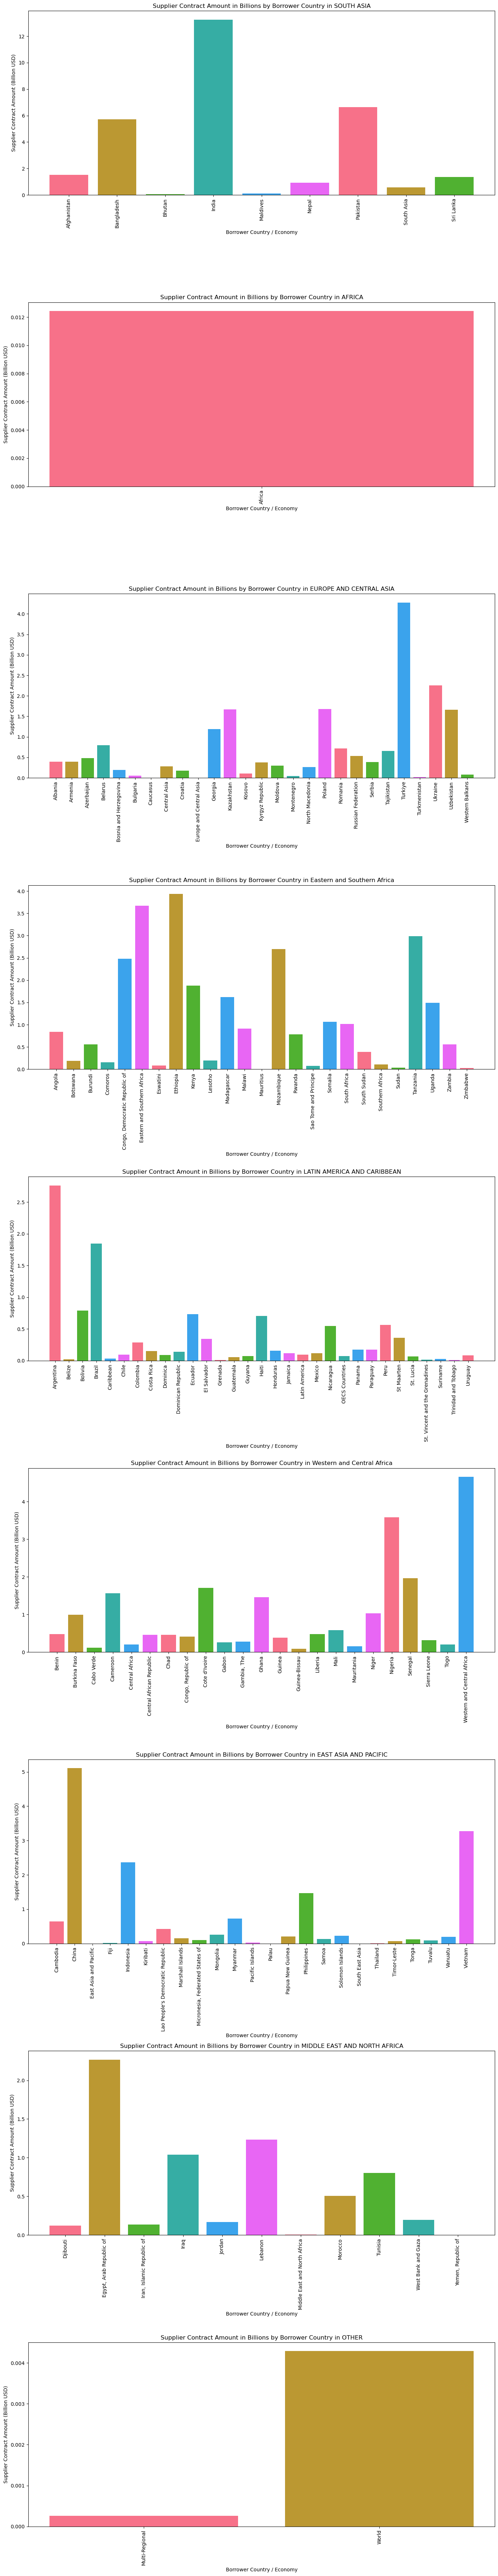

In [24]:
# Get the unique regions
unique_regions = country_region_sum['Region'].unique()

# Set up the figure size
plt.figure(figsize=(14, 8 * len(unique_regions)))

# Set up color palette
colors = sns.color_palette('husl')

# Loop through each region and create a subplot
for i, region in enumerate(unique_regions):
    plt.subplot(len(unique_regions), 1, i + 1)
    region_data = country_region_sum[country_region_sum['Region'] == region]
    plt.bar(region_data['Borrower Country / Economy'], region_data['Supplier Contract Amount (Billion USD)'], color=colors[:len(region_data)])
    plt.xticks(rotation=90)
    plt.title(f'Supplier Contract Amount in Billions by Borrower Country in {region}')
    plt.xlabel('Borrower Country / Economy')
    plt.ylabel('Supplier Contract Amount (Billion USD)')

plt.tight_layout()
plt.savefig('output/supplier_contract_amount_in_billions_by_region.png')
plt.show()
